# Projeto - Perceptron e MLP

In [1]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#  libs básicas de manipulação e plotagem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preparação de dados
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# modelo de MA
from sklearn.svm import SVC

# otimiação do modelo
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold


# métricas de avaliação
from sklearn.metrics import make_scorer , recall_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score

# Perceptron
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import TruePositives
from keras.wrappers.scikit_learn import KerasClassifier

# configurações de plotagem
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn-dark')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv('/content/drive/MyDrive/data_sets/breast_cancer/breast_cancer.csv', index_col='id')
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
le = LabelEncoder() 
y = le.fit_transform(df['diagnosis'])

In [6]:
X = df #features

X.drop(columns=['diagnosis'], inplace = True);

In [7]:
# função com a pipeline
def pipe_breast_cancer(X, y):


     # Definir quem são as variáveis independentes e a variável dependente
    X = X
    y = y

    # Particiona os dados a fim de poder avaliar o modelo ao fim do processo
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=42, 
                                                        stratify=y)

  
    # Resample
    sm = RandomOverSampler(random_state= 42)

    X_train, y_train = sm.fit_resample(X_train, y_train)


    # Preprocessamento de dados
    # ==========================================================

    pipe_features_num = Pipeline([("std", StandardScaler())])

    features_num = X_train.select_dtypes(include=np.number).columns.tolist()


    # ==========================================================

    pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num)])

    return pre_processador, X_train, y_train, X_test, y_test

In [8]:
pre_processador, X_train, y_train, X_test, y_test = pipe_breast_cancer(X, y)

In [9]:
pipe_svm  = Pipeline([('pre_processador', pre_processador),
                      ("svm", SVC(probability= True))])


In [10]:
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                           

In [11]:
SVC().get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [12]:
params_grid = {"svm__kernel": Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
               "svm__gamma": ['scale', 'auto'],
               "svm__degree": Integer(1, 8),
               "svm__decision_function_shape": ['ovo', 'ovr'],
               "svm__C": Real(1e-6, 1e+6, prior='log-uniform')
               }
splitter = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


# scoring =  

# log-uniform: understand as search over p = exp(x) by varying x
opt = BayesSearchCV(
    pipe_svm,
    params_grid,
    scoring='recall',
    n_iter=100,
    cv=splitter,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best params: %s" % str(opt.best_params_))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [13]:
def metricas_classificacao(estimator):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")
    print('\n\n')
    

    y_pred_train = estimator.predict(X_train)
    y_probs_train = estimator.predict_proba(X_train)[:, 1]


    print(classification_report(y_train, y_pred_train))
    print('\n\n')

    #===============================================
    
    conf_matrix_train = confusion_matrix(y_train, y_pred_train)

    # constrindo labels para o treino
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = (['{0:0.0f}'.format(value) for value in 
                     conf_matrix_train.flatten()])
    
    labels = [f'{v1}\n\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
    
    labels = np.asarray(labels).reshape(2,2)

    plot = sns.heatmap(conf_matrix_train,
                       xticklabels= ['Benigno', 'Maligno'],
                       yticklabels= ['Benigno', 'Maligno'],
                       fmt='', 
                       annot = labels, 
                       linewidths=.6)
    
    plt.title('\nDIAGNÓSTICO DE CÂNCER\n', fontsize = 20) 
    plt.xlabel('\nPredições do Modelo', fontsize = 15) 
    plt.ylabel('\nDiagnóstico', fontsize = 15) 
    plt.show() 

    print('\n\n\n\n')

    #================================================
    # Curva AUC

    disp = RocCurveDisplay.from_predictions(y_train, y_probs_train)
    disp.ax_.set_title(f"AUC: {roc_auc_score(y_train, y_probs_train):.3f}", fontsize=16)
    x = np.linspace(0, 1, 100)
    plt.plot(x, x, ls=":", color="black")
    plt.show()


    # ============================================

    print("\nMétricas de avaliação de teste:")
    print('\n\n')

    y_pred_test = estimator.predict(X_test)
    y_probs_test = estimator.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred_test))

    print('\n\n')

    conf_matrix_test = confusion_matrix(y_test, y_pred_test)


    # constrindo labels para o teste
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = (['{0:0.0f}'.format(value) for value in 
                     conf_matrix_test.flatten()])
    
    labels = [f'{v1}\n\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
    
    labels = np.asarray(labels).reshape(2,2)


    
    plot = sns.heatmap(conf_matrix_test,
                       xticklabels= ['Benigno', 'Maligno'],
                       yticklabels= ['Benigno', 'Maligno'],
                       fmt= '',
                       annot = labels, 
                       linewidths=.6)
    plt.title('\nDIAGNÓSTICO DE CÂNCER\n', fontsize = 20)
    plt.xlabel('\nPredições do Modelo', fontsize = 15) 
    plt.ylabel('\nDiagnóstico', fontsize = 15) 
    plt.show()


    
    print('\n\n\n\n')

    disp = RocCurveDisplay.from_predictions(y_test, y_probs_test)
    disp.ax_.set_title(f"AUC: {roc_auc_score(y_test, y_probs_test):.3f}", fontsize=16)
    x = np.linspace(0, 1, 100)
    plt.plot(x, x, ls=":", color="black")
    plt.show()
    


Métricas de avaliação de treino:



              precision    recall  f1-score   support

           0       0.98      1.00      0.99       285
           1       1.00      0.98      0.99       285

    accuracy                           0.99       570
   macro avg       0.99      0.99      0.99       570
weighted avg       0.99      0.99      0.99       570






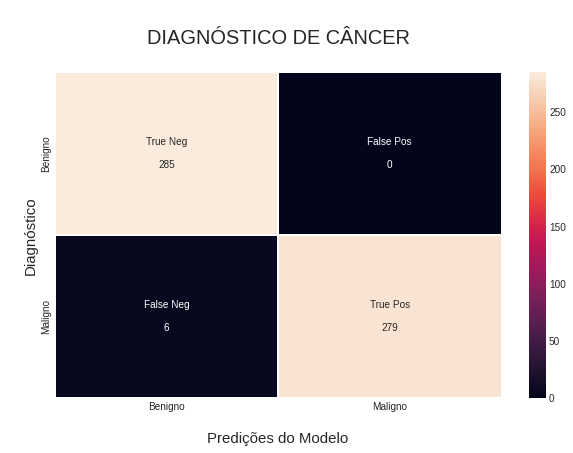

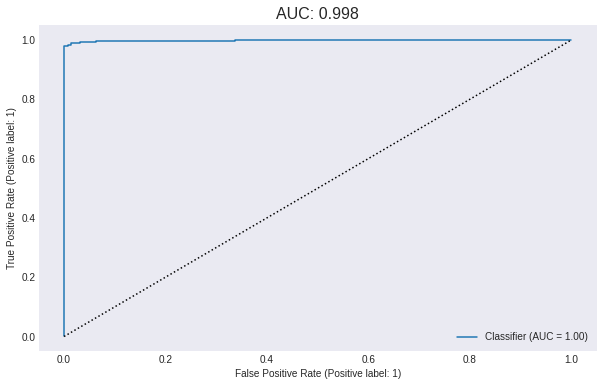


Métricas de avaliação de teste:



              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114






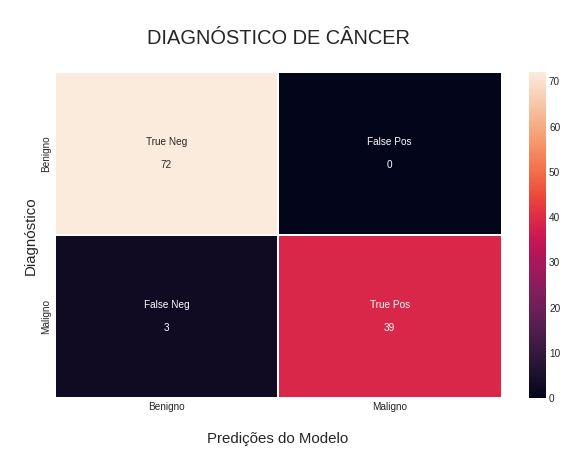

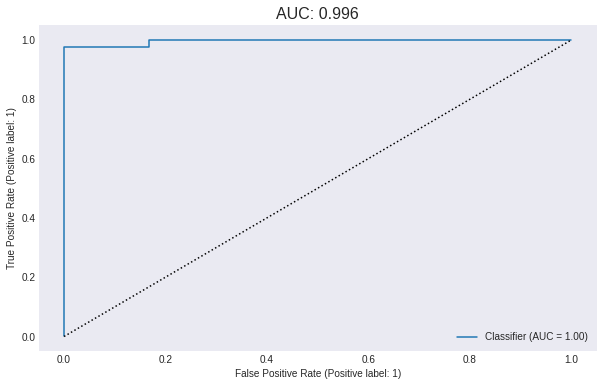

In [14]:
metricas_classificacao(pipe_svm)


Métricas de avaliação de treino:



              precision    recall  f1-score   support

           0       0.99      1.00      1.00       285
           1       1.00      0.99      1.00       285

    accuracy                           1.00       570
   macro avg       1.00      1.00      1.00       570
weighted avg       1.00      1.00      1.00       570






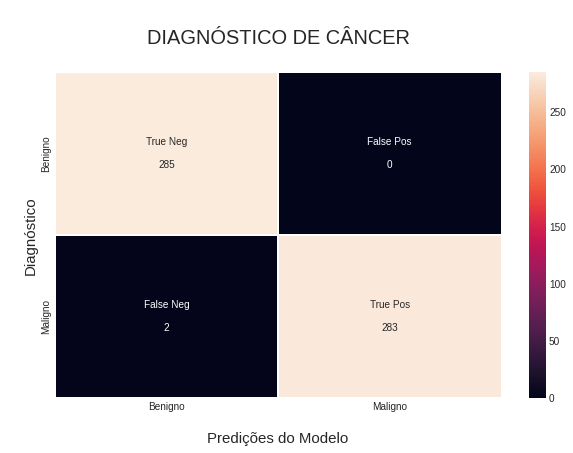

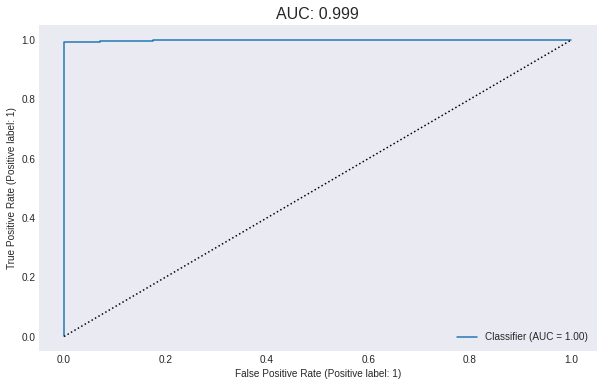


Métricas de avaliação de teste:



              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114






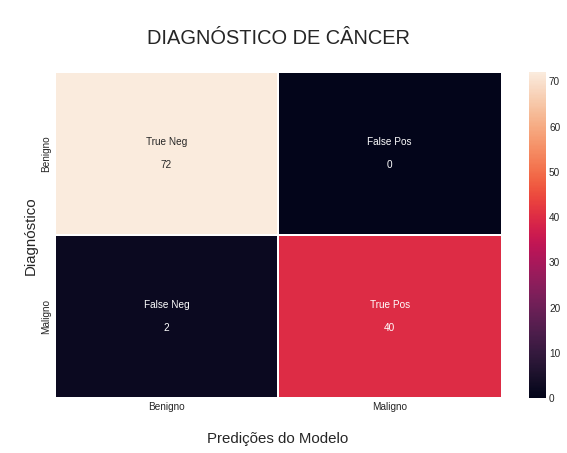

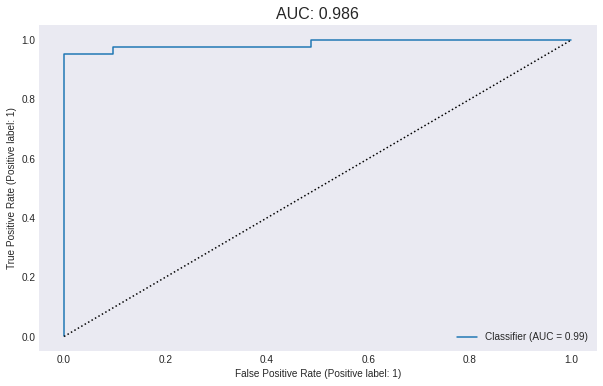

In [15]:
metricas_classificacao(opt)

In [16]:
print(opt.score(X_test, y_test))

0.9523809523809523


In [17]:
def model():
  c = 1
  # Instancia a Rede
  model = Sequential()

  # Definindo camada de input e primeira camada oculta
  model.add(Dense(17, 
              input_dim = X.shape[1]))    # número de colunas 
  model.add(Activation('relu'))

  # Definir segunda camada oculta
  model.add(Dense(34))
  model.add(Activation('relu'))

  # Definir terceira camada oculta
  model.add(Dense(68))
  model.add(Activation('relu'))

   # Definir quarta camada oculta
  model.add(Dense(34))
  model.add(Activation('relu'))


  # Camada de output
  model.add(Dense(c))
  model.add(Activation('sigmoid'))

  model.compile(loss = 'binary_crossentropy',
                     optimizer = 'adam',
                     metrics=[TruePositives()])

  pesos_iniciais = model.get_weights()

  return model

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10,
                               min_delta = 0.001,
                               verbose=0, 
                               mode='auto')

In [19]:
pipe_rnn = Pipeline([
                ('pre_processador', pre_processador),
                ('rnn', KerasClassifier(build_fn=model, 
                            nb_epoch=100, 
                            validation_split=0.1, 
                            callbacks=[early_stopping]))
                  ])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [20]:
pipe_rnn.fit(X_train, y_train)

17/17 [==============================] - 1s 20ms/step - loss: 0.6003 - true_positives: 209.0000 - val_loss: 0.3967 - val_true_positives: 45.0000


Pipeline(steps=[('pre_processador',
                 ColumnTransformer(transformers=[('transf_num',
                                                  Pipeline(steps=[('std',
                                                                   StandardScaler())]),
                                                  ['radius_mean',
                                                   'texture_mean',
                                                   'perimeter_mean',
                                                   'area_mean',
                                                   'smoothness_mean',
                                                   'compactness_mean',
                                                   'concavity_mean',
                                                   'concave points_mean',
                                                   'symmetry_mean',
                                                   'fractal_dimension_mean',
                                           


Métricas de avaliação de treino:



              precision    recall  f1-score   support

           0       0.85      0.96      0.90       285
           1       0.96      0.84      0.89       285

    accuracy                           0.90       570
   macro avg       0.90      0.90      0.90       570
weighted avg       0.90      0.90      0.90       570






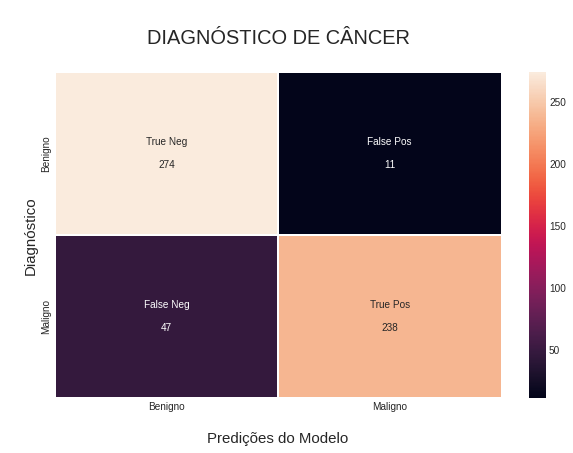

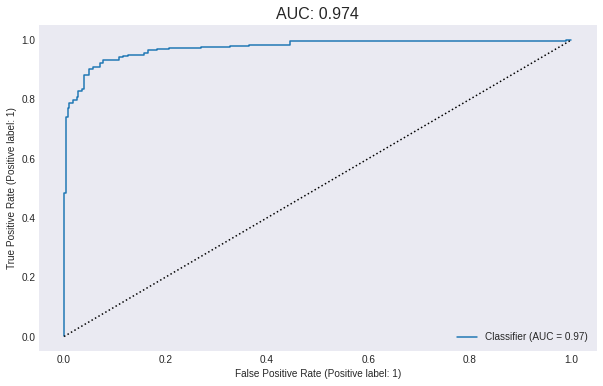


Métricas de avaliação de teste:



              precision    recall  f1-score   support

           0       0.88      0.99      0.93        72
           1       0.97      0.76      0.85        42

    accuracy                           0.90       114
   macro avg       0.92      0.87      0.89       114
weighted avg       0.91      0.90      0.90       114






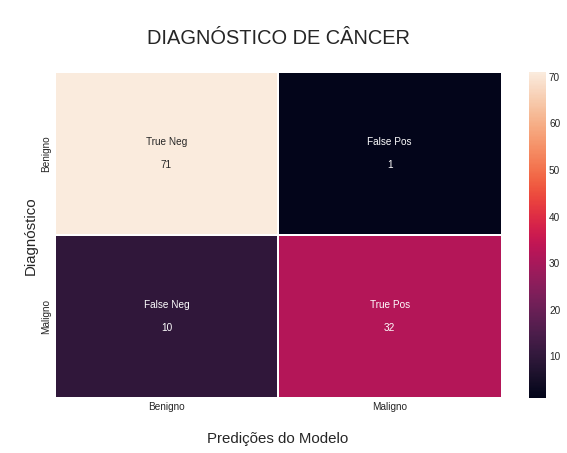

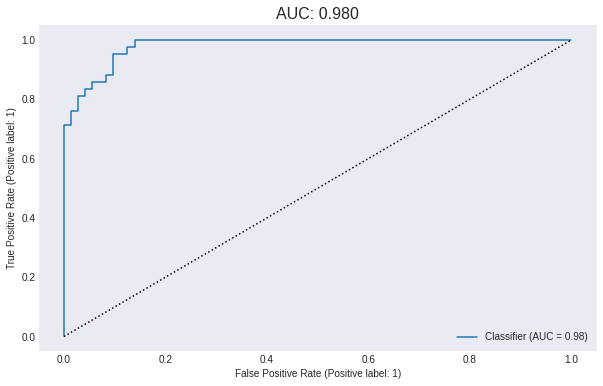

In [21]:
metricas_classificacao(pipe_rnn)